<a href="https://colab.research.google.com/github/Eyob512/3D-CNN-COVID-19-Classification/blob/main/2D_image_covid19_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification from scratch

**Author:** [EYOB AMARE TESFAYE](https://www.linkedin.com/in/eyob-amare-0651b2209/)<br>
**Date created:** 2021/11/27<br>
**Last modified:** 2021/11/29<br>
**Description:** Train a 3D convolutional neural network to predict presence of pneumonia.

## Setup


In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Load the data:


In [7]:
import zipfile
import os
os.makedirs("CT-2D")

# Unzip data in the newly created directory.
with zipfile.ZipFile("/content/drive/MyDrive/CT-DATA-2D.zip", "r") as z_fp:
    z_fp.extractall("./CT-2D/")


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!ls CT-2D/CT-DATA-2D/

negative  positive


## Generate a `Dataset`


In [9]:
image_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "CT-2D/CT-DATA-2D/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "CT-2D/CT-DATA-2D/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
)


Found 2481 files belonging to 2 classes.
Using 1985 files for training.
Found 2481 files belonging to 2 classes.
Using 496 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "positive"
 and label 0 is "negative".


Dimension of the CT scan is: (128, 128, 1)


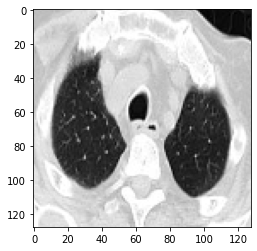

In [10]:
import matplotlib.pyplot as plt
import numpy as np

data = train_ds.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :]), cmap="gray")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


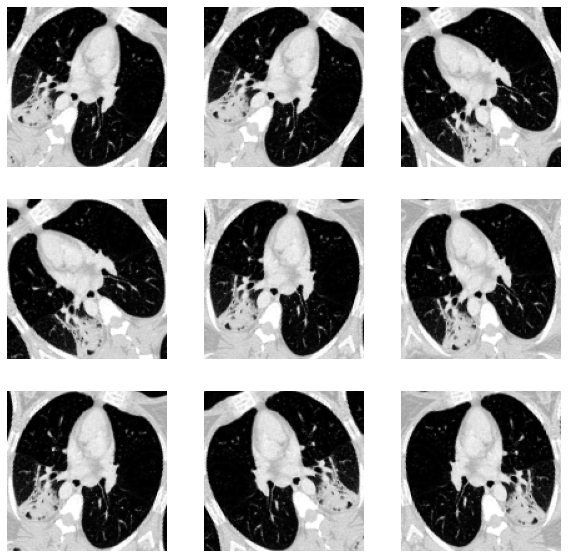

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        image = augmented_images[0]
        plt.imshow(np.squeeze(image[:, :]), cmap="gray")
        plt.axis("off")


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [13]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


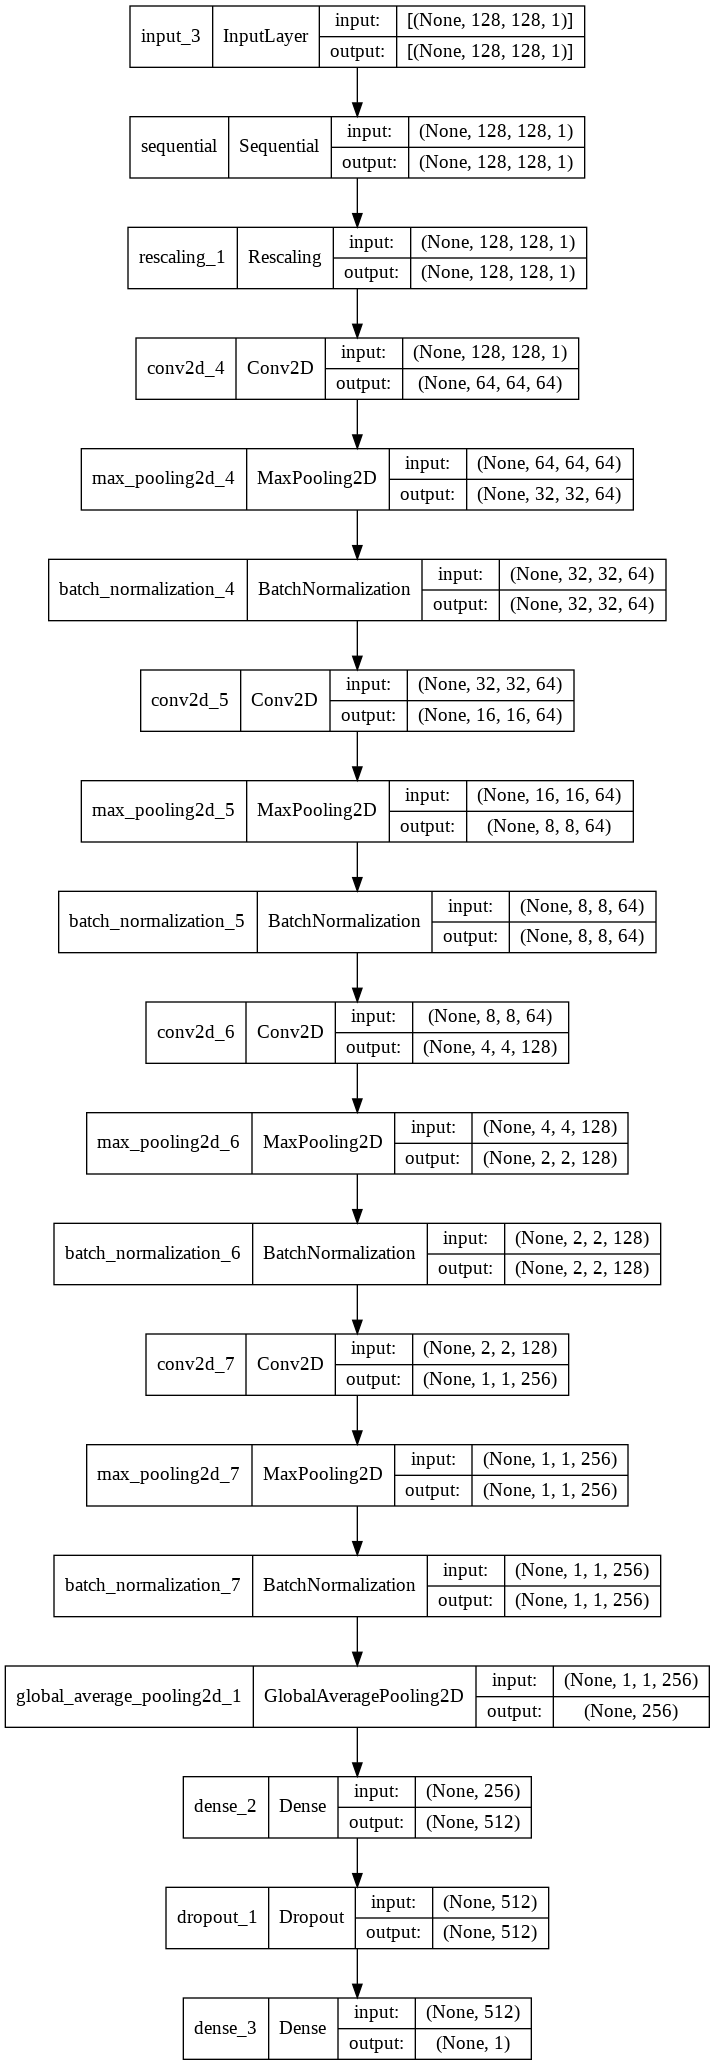

In [15]:

def get_model(width=128, height=128):

    inputs = keras.Input((width, height, 1))

    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=256, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="2dcnn")
    return model


# Build model.
model = get_model(width=128, height=128)
#model.summary()
keras.utils.plot_model(model, show_shapes=True)


In [16]:
model.summary()

Model: "2dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 1)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                             

## Train the model


In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data=val_ds,
)


Epoch 1/50
63/63 [==============================] - 16s 77ms/step - loss: 0.5375 - accuracy: 0.7481 - val_loss: nan - val_accuracy: 0.4919
Epoch 2/50
63/63 [==============================] - 9s 124ms/step - loss: 0.4058 - accuracy: 0.8262 - val_loss: nan - val_accuracy: 0.4919
Epoch 3/50
63/63 [==============================] - 9s 124ms/step - loss: 0.3695 - accuracy: 0.8463 - val_loss: nan - val_accuracy: 0.4919
Epoch 4/50
63/63 [==============================] - 9s 126ms/step - loss: 0.3229 - accuracy: 0.8670 - val_loss: nan - val_accuracy: 0.4919
Epoch 5/50
63/63 [==============================] - 9s 124ms/step - loss: 0.3089 - accuracy: 0.8720 - val_loss: nan - val_accuracy: 0.4919
Epoch 6/50
63/63 [==============================] - 10s 140ms/step - loss: 0.2836 - accuracy: 0.8811 - val_loss: nan - val_accuracy: 0.4919
Epoch 7/50
63/63 [==============================] - 9s 124ms/step - loss: 0.2688 - accuracy: 0.8877 - val_loss: nan - val_accuracy: 0.4919
Epoch 8/50
63/63 [========

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [ ]:
model.load_weights("/content/save_at_48.h5")
img = keras.preprocessing.image.load_img(
    "CT-2D/CT-DATA-2D/positive/Covid (1).png", target_size=image_size, color_mode="grayscale",
)
img_array = keras.preprocessing.image.img_to_array(img)

prediction = model.predict(np.expand_dims(img_array, axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["negative", "positive"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )


FileNotFoundError: ignored